In [1]:
# !curl -O http://vis-www.cs.umass.edu/lfw/lfw.tgz 
# !tar -xvzf lfw.tgz

## Glasses Detector

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
glasses_data=pd.read_csv("data2.csv",names=["Image","Glasses"])
glasses_data

,Image,Glasses
0,./lfw/Winona_Ryder/Winona_Ryder_0004.jpg,0
1,./lfw/Jason_Keep/Jason_Keep_0001.jpg,0
2,./lfw/Colin_Powell/Colin_Powell_0013.jpg,1
3,./lfw/Sam_Torrance/Sam_Torrance_0001.jpg,0
4,./lfw/Tonga/Tonga_0001.jpg,0
...,...,...
1678,./lfw/Martin_Sheen/Martin_Sheen_0002.jpg,0
1679,./lfw/Lisa_Girman/Lisa_Girman_0001.jpg,0
1680,./lfw/Brian_Clemens/Brian_Clemens_0001.jpg,0
1681,./lfw/Larry_Donald/Larry_Donald_0001.jpg,0


In [4]:
glasses_data.describe()

,Glasses
count,1683.000000
mean,0.171717
std,0.377247
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


From above we can see that 20% of the dataset wear glasses, and the other 80% don't, but should we balance the dataset? I think we shouldn't as a good classifier should be able to get beyond 82% accuracy as it would of learned what are glasses and what aren't. If this becomes a problem, we can balance the dataset.

Lets have 20% set as test of the data and hold 20% of the data of the training set as validation.

In [5]:
glasses_train, glasses_test=train_test_split(glasses_data,test_size=0.2)
glasses_train, glasses_validation=train_test_split(glasses_train,test_size=0.2)

In [6]:
glasses_train.loc[glasses_train["Glasses"]==1].count()

Image      188
Glasses    188
dtype: int64

In [7]:
glasses_test

,Image,Glasses
251,./lfw/George_W_Bush/George_W_Bush_0427.jpg,0
830,./lfw/Tom_Ridge/Tom_Ridge_0021.jpg,0
669,./lfw/Julie_Andrews/Julie_Andrews_0001.jpg,0
1202,./lfw/Paul_ONeill/Paul_ONeill_0002.jpg,1
1018,./lfw/Alexander_Downer/Alexander_Downer_0004.jpg,1
...,...,...
869,./lfw/Jiri_Novak/Jiri_Novak_0004.jpg,0
206,./lfw/John_Negroponte/John_Negroponte_0013.jpg,0
423,./lfw/John_Reid/John_Reid_0003.jpg,0
1372,./lfw/Larry_Pleau/Larry_Pleau_0001.jpg,0


In [8]:
glasses_validation.loc[glasses_validation["Glasses"]==1].count()

Image      44
Glasses    44
dtype: int64

In [9]:
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import torchvision

In [10]:
unique,counts=np.unique(glasses_validation.to_numpy()[:,1],return_counts=True)


In [11]:
class GlassesDataset(torch.utils.data.Dataset):
    def __init__(self,df, transform=None, target_transform=None,autoBalance=True):
        super().__init__()
        # self.df=df
        if autoBalance:
            unique,counts=np.unique(df.to_numpy()[:,1],return_counts=True)
            biggest_count=max(counts)

            data=[]
            # balance df
            for classification in unique:
                
                out=df.to_numpy()[np.where(df.to_numpy()[:,1]==classification)]
                data.append(pd.DataFrame(out).sample(biggest_count,replace=True))
            
            # Merge df
            self.df=pd.concat(data)
        else:
            self.df=df


            

        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        file_path=self.df.iloc[idx,0]
        image=read_image(file_path)/255
        label=self.df.iloc[idx,1]
        label=torch.tensor(label,dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image,label



In [12]:
# torch.empty(3, dtype=torch.long).random_(5)
# torch.randn(3, 5, requires_grad=True)
GlassesDataset(glasses_train)

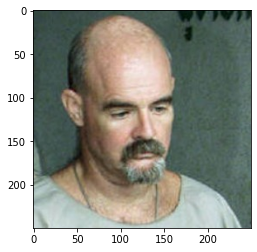

In [13]:
plt.imshow(GlassesDataset(glasses_train).__getitem__(9)[0].numpy().transpose(1,2,0))
DataLoader(GlassesDataset(glasses_train),num_workers=4,batch_size=32,shuffle=True)

for i in DataLoader(GlassesDataset(glasses_train),batch_size=32,shuffle=True):
    # print(i)
    break


In [14]:
# Get all images
import glob,os
class PredictDataset(Dataset):
    def __init__(self,images_paths,transform=None):

        self.transform=transform
        
        self.images_paths=images_paths
    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self,idx):
        file_path=self.images_paths[idx]
        image=read_image(file_path)/255
        if self.transform:
            image = self.transform(image)

        return image


In [15]:
image_paths=[]
for filename in glob.iglob(os.path.join('lfw/')+'**/*.jpg', recursive=True):
            image_paths.append(filename)
predictionDataloader=DataLoader(PredictDataset(image_paths,torchvision.transforms.Compose([torchvision.transforms.Resize((128,128))])),1,shuffle=False,num_workers=8)
len(image_paths)

13233

In [16]:

class GlassesDataModule(pl.LightningDataModule):
    def __init__(self,train,test,val,batch_size=32,num_workers=4):
        super().__init__()
        self.train=train
        self.test=test
        self.val=val
        self.batch_size=batch_size
        self.num_workers=num_workers
        self.transforms=torchvision.transforms.Compose([torchvision.transforms.Resize((128,128))])
        
        
        self.testDataset=GlassesDataset(self.test,self.transforms,autoBalance=False)
        self.valDataset=GlassesDataset(self.val,self.transforms,autoBalance=False)
        
    def train_dataloader(self):
        # torchvision.transforms.ColorJitter(0.3,0.3,0.3,0.3)
        self.train_transform=torchvision.transforms.Compose([self.transforms,torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.RandomHorizontalFlip(),torchvision.transforms.RandomRotation((-180,180))]),p=0.7)])
        self.trainDataset=GlassesDataset(self.train,self.train_transform)

        return DataLoader(self.trainDataset,batch_size=self.batch_size,shuffle=True,num_workers=self.num_workers)
    def test_dataloader(self):
        return DataLoader(self.testDataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers)
    def val_dataloader(self):
        return DataLoader(self.valDataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers)
        


In [17]:
# img=GlassesDataset(glasses_train).__getitem__(9)[0]

In [18]:
# plt.imshow()(img).numpy().transpose(1,2,0))

torch.Size([32, 3, 128, 128])
tensor(1)


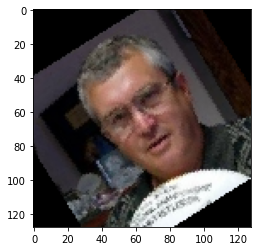

In [19]:
if __name__ == '__main__':
    module=GlassesDataModule(glasses_train,glasses_test,glasses_validation,num_workers=0)
    # module.setup(stage="fit")
    for a in module.train_dataloader():
        print(a[0].shape)
        plt.imshow(a[0][0].numpy().transpose(1,2,0))
        print(a[1][0])
        break

RESNET Block

We can keep the shape the same by: P = (F-1)/2 
S = 1
F = filter size
P = padding


In [20]:
# If decrease is True then lets decrease the output size by half
class ResNetBlock(torch.nn.Module):
    def __init__(self,filter_in,decrease=False,filters_out=-1) -> None:
        super().__init__()
        self.decrease=decrease
        
        if not decrease:
            filters_out=filter_in
            stride=1
        else:
            stride=2
            # Setup decreasing the input by half 
            self.halfInput=torch.nn.Sequential(
                torch.nn.BatchNorm2d(filter_in),
                torch.nn.LeakyReLU(),
                torch.nn.Conv2d(filter_in,filters_out,kernel_size=3,stride=2,padding=1, bias=False),
            )
        
        # Main nn
        self.main = torch.nn.Sequential(
            torch.nn.BatchNorm2d(filter_in),
            torch.nn.LeakyReLU(),
            #If we want to decrease the output size by half then we need to use a stride of 2 otherwise we can use a stride of 1
            torch.nn.Conv2d(filter_in,filters_out,kernel_size=3,padding=1,stride=stride, bias=False),
            torch.nn.BatchNorm2d(filters_out),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(filters_out,filters_out,kernel_size=3,padding=1, bias=False),
        )
    def forward(self,x):
        if self.decrease:
            x2=self.main(x)
            x=self.halfInput(x)
            return x+x2
        else:
            return self.main(x)

In [21]:
a=ResNetBlock(3,decrease=True,filters_out=256)
b=torch.rand(12,3,128,128)
a(b).shape

torch.Size([12, 256, 64, 64])

In [22]:
%load_ext tensorboard
%tensorboard --logdir lightning-logs

Reusing TensorBoard on port 6007 (pid 112759), started 5:03:00 ago. (Use '!kill 112759' to kill it.)

In [23]:
class GlassesModel(pl.LightningModule):
    def __init__(self,cin=32,num_big_blocks=3,num_classes=2):
        super().__init__()
        # Input is a tensor of size (batch_size,3,50,50)
        # Lets up the number of filters to 32
        self.up=torch.nn.Sequential(
            torch.nn.Conv2d(3,cin,kernel_size=3,padding=1,bias=False),
        )
        # Lets set some ResNet blocks and for every 3 blocks we will decrease the output size by half
        self.resnet_blocks=[]
        for i in range(3*num_big_blocks):
            if i%3==0:
                resnet_block=ResNetBlock(cin,True,cin*2)
                cin=cin*2
                self.resnet_blocks.append(resnet_block)
            else:
                resnet_block=ResNetBlock(cin)
                self.resnet_blocks.append(resnet_block)
        
        self.resnet_blocks=torch.nn.Sequential(*self.resnet_blocks)
        # Lets average pool the output of the last ResNet block
        self.output=torch.nn.Sequential(
            torch.nn.Linear(cin,1000),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1000,num_classes)

        )
        

        # self.linear=torch.nn.Linear(50*50*3,1)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01,momentum=0.01)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer] , [scheduler]

    def forward(self,x):
        # x=torch.flatten(x,start_dim=1)
        # x=self.linear(x)
        # x=torch.sigmoid(x)
        x=self.up(x)
        x=self.resnet_blocks(x)
        x=x.mean(dim=(-2,-1))
        x=self.output(x)
        return x

    def training_step(self,batch,batch_idx):
        x,y=batch
        y_hat=self(x)
        logSoftmax=torch.nn.LogSoftmax(dim=1)
        y_hat=logSoftmax(y_hat)

        NllLoss=torch.nn.NLLLoss()
        loss=NllLoss(y_hat,y)

        predicted_classes=torch.topk(y_hat,1,dim=1).indices.reshape(-1)

        correct=torch.count_nonzero(predicted_classes==y)

        self.log("train-accuracy",correct/len(batch[0]),prog_bar=True)
        
        # loss = torch.nn.CrossEntropyLoss()
        
        self.log("train-crossEntropyLoss",loss)
        
        # loss=loss(y_hat,y)
        
        return loss
    def validation_step(self,batch,batch_idx) :
        x,y=batch
        y_hat=self(x)
        logSoftmax=torch.nn.LogSoftmax(dim=1)
        y_hat=logSoftmax(y_hat)

        NllLoss=torch.nn.NLLLoss()
        loss=NllLoss(y_hat,y)

        predicted_classes=torch.topk(y_hat,1,dim=1).indices.reshape(-1)
        correct=torch.count_nonzero(predicted_classes==y)

        self.log("val-accuracy",correct/len(batch[0]),prog_bar=True)
        
        # loss = torch.nn.CrossEntropyLoss()
        
        self.log("val-crossEntropyLoss",loss,prog_bar=True)
        
        # loss=loss(y_hat,y)
        
        return loss
        
    # def test_step(self,batch,batch_idx):
    #     x,y=batch
    #     y_hat=self(x)
    #     loss = torch.nn.MSELoss()
    #     y_hat=torch.flatten(y_hat,start_dim=0)
    #     loss=loss(y_hat,y)
    #     return loss.to(torch.float32)

In [24]:
module=GlassesDataModule(glasses_train,glasses_test,glasses_validation,num_workers=8,batch_size=32)
trainer=pl.Trainer(log_every_n_steps=5,max_epochs=1000,gpus=1)
model=GlassesModel(num_big_blocks=3)

# lr_finder = trainer.tuner.lr_find(model,module)
# # Results can be found in
# print(lr_finder.suggestion())

# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()
# model=model.load_from_checkpoint("lightning_logs/version_11/checkpoints/epoch=236-step=13034.ckpt")
trainer.fit(model,module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | up            | Sequential | 864   
1 | resnet_blocks | Sequential | 4.7 M 
2 | output        | Sequential | 259 K 
---------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.640    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/asimpoptani/Glasses-Minidetector/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:

model(torch.rand(1,3,128,128))

tensor([[-0.0270,  0.0502]], grad_fn=<AddmmBackward0>)

In [25]:
predictions=trainer.predict(model,predictionDataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _fee

In [26]:
image_index=0
for predicition in predictions:
    # print(predicition[0])
    image=torch.softmax(predicition,dim=1)
    # print(predicition.shape)
    print(str(torch.argmax(image)),image_paths[image_index])
    image_index+=1


tensor(0) lfw/Lou_Piniella/Lou_Piniella_0002.jpg
tensor(0) lfw/Lou_Piniella/Lou_Piniella_0003.jpg
tensor(0) lfw/Lou_Piniella/Lou_Piniella_0001.jpg
tensor(0) lfw/Harald_Ringstorff/Harald_Ringstorff_0001.jpg
tensor(0) lfw/Muhammad_Saeed_al-Sahhaf/Muhammad_Saeed_al-Sahhaf_0003.jpg
tensor(1) lfw/Muhammad_Saeed_al-Sahhaf/Muhammad_Saeed_al-Sahhaf_0002.jpg
tensor(1) lfw/Muhammad_Saeed_al-Sahhaf/Muhammad_Saeed_al-Sahhaf_0004.jpg
tensor(1) lfw/Muhammad_Saeed_al-Sahhaf/Muhammad_Saeed_al-Sahhaf_0001.jpg
tensor(0) lfw/Muhammad_Saeed_al-Sahhaf/Muhammad_Saeed_al-Sahhaf_0005.jpg
tensor(0) lfw/Thomas_Gottschalk/Thomas_Gottschalk_0001.jpg
tensor(0) lfw/Jennifer_Pena/Jennifer_Pena_0001.jpg
tensor(1) lfw/Farouk_Kaddoumi/Farouk_Kaddoumi_0001.jpg
tensor(0) lfw/Mike_Duke/Mike_Duke_0001.jpg
tensor(0) lfw/Barbara_Becker/Barbara_Becker_0001.jpg
tensor(0) lfw/Tina_Brown/Tina_Brown_0001.jpg
tensor(1) lfw/Darrell_Royal/Darrell_Royal_0001.jpg
tensor(1) lfw/Edward_Arsenault/Edward_Arsenault_0001.jpg
tensor(0) lfw/D